In [1]:
import mplpub
import numpy as np
from ase import Atoms
from ase.io import read
from ase.spacegroup.symmetrize import FixSymmetry
from ase.units import GPa, kB
from calorine.calculators import CPUNEP
from calorine.tools import get_force_constants, relax_structure
from matplotlib import pyplot as plt, colormaps
from pandas import DataFrame, read_json, concat as pd_concat
from phonopy import load, Phonopy, PhonopyQHA
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.units import Avogadro, EvTokJmol, kb_J, THzToEv
from seekpath import get_explicit_k_path
from tqdm import tqdm

R = kb_J * Avogadro
mplpub.setup(template='acs')

In [2]:
def get_props(
    ph, classical,
    mesh=[40, 40, 40],
    t_min=1, t_max=700, t_step=1,
    freq_min=-5, freq_max=20, freq_pitch=0.05,
):
    # evaluate frequencies on the specified q-point mesh
    ph.run_mesh(mesh)

    # compute thermal properties
    ph.run_thermal_properties(t_min=t_min, t_max=t_max, t_step=t_step, classical=classical)

    # turn results into DataFrame
    tp_dict = ph.get_thermal_properties_dict()
    df_thermo = DataFrame(tp_dict)
    df_thermo['temperature'] = df_thermo.temperatures
    del df_thermo['temperatures']

    # add columns with properties in more convenient units for plotting
    natoms = len(get_structure(ph))
    df_thermo['free_energy_eV'] = df_thermo.free_energy / EvTokJmol / natoms
    df_thermo['entropy_kB'] = df_thermo.entropy / R / natoms
    df_thermo['heat_capacity_kB'] = df_thermo.heat_capacity / R / natoms

    # density of states
    ph.run_total_dos(freq_min=freq_min, freq_max=freq_max, freq_pitch=freq_pitch)
    dos_dict = ph.get_total_dos_dict()
    df_dos = DataFrame(dos_dict)
    df_dos['frequency'] = df_dos.frequency_points
    del df_dos['frequency_points']
    df_dos.total_dos /= natoms

    return df_thermo, df_dos

In [3]:
def get_structure(phonon):
    structure_ph = phonon.primitive
    structure_ase = Atoms(symbols=structure_ph.symbols, cell=structure_ph.cell,
                          scaled_positions=structure_ph.scaled_positions, pbc=True)
    return structure_ase

In [4]:
def labels_to_latex(labels_in):
    labels = [r'$\UG{\Gamma}$' if m == 'GAMMA' else m for m in labels_in]
    labels = [m.replace('SIGMA', r'$\UG{\Sigma}$') if m.startswith('SIGMA') else m for m in labels]
    labels = [m.replace('_', '$_') + '$' if '_' in m else m for m in labels]
    return labels

colors = {
    'BaZrS3-spg140-I4mcm': 'C0',
    'BaZrS3-spg62-Pnma': 'C1',
#    'BaZrS3-spg62-Pnma-DELTA': 'C2',
}

labels = {
    'BaZrS3-spg140-I4mcm': 'I4/mcm',
    'BaZrS3-spg62-Pnma': 'Pnma',
#    'BaZrS3-spg62-Pnma-DELTA': 'delta',
}

In [21]:
xc = 'HSE'
model_filename = 'nep.txt'
supercell_matrix = [4, 4, 4]

phonons = {}
for sname in labels:
    print(f'sname: {sname}')
    phonons[sname] = {}
    for volsc in tqdm(np.arange(0.92, 1.11, 0.01)):
        volsc = np.around(volsc, decimals=3)
        outfile = f'runs-{xc}/phonon-{sname}-volsc{volsc:.3f}.yaml'
        try:
            ph = load(outfile)
        except:
            structure = read(f'structures/{sname}.xyz')
            cell = structure.cell[:] * volsc ** (1 / 3)
            structure.set_cell(cell, scale_atoms=True)
            calculator = CPUNEP(model_filename)
            structure.calc = calculator
            structure.set_constraint(FixSymmetry(structure))
            relax_structure(structure, constant_volume=True)
            ph = get_force_constants(structure, calculator, supercell_matrix=supercell_matrix)
            ph.save(outfile)

        phonons[sname][volsc] = ph

sname: BaZrS3-spg140-I4mcm


  0%|          | 0/20 [00:00<?, ?it/s]/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['transformation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_rotation_matrix']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interfa

sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


In [22]:
volsc = 1.0

paths = {}
dfs_phonons = {}
for sname in phonons:
    phonon = phonons[sname][volsc]

    structure = get_structure(phonon)
    structure_tuple = (structure.cell[:], structure.get_scaled_positions(), structure.numbers)
    path = get_explicit_k_path(structure_tuple)
    paths[sname] = path.copy()

    phonon.run_band_structure([path['explicit_kpoints_rel']])
    band = phonon.get_band_structure_dict()

    df = DataFrame(band['frequencies'][0])
    df.index = path['explicit_kpoints_linearcoord']
    dfs_phonons[sname] = df 

/Users/prakriti/miniconda3/envs/nep2/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


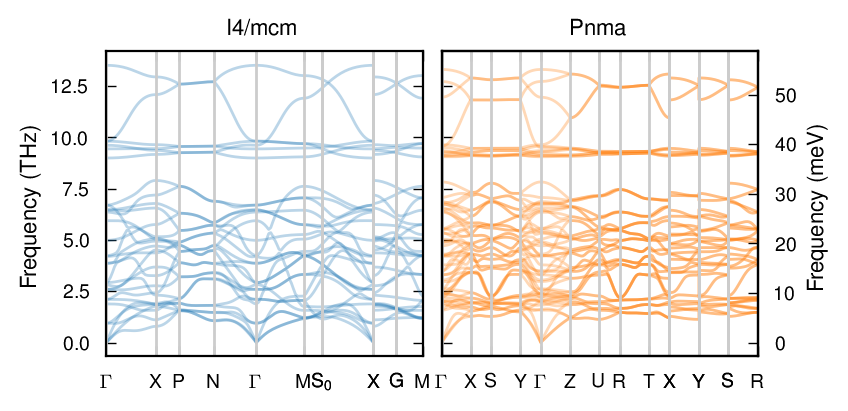

In [23]:
ncols = len(dfs_phonons)

fig, axes = plt.subplots(
    figsize=(4.2, 2.1),
    ncols=len(dfs_phonons),
    sharey=True,
    dpi=200,
)

for icol, (sname, df) in enumerate(dfs_phonons.items()):
    ax = axes[icol]
    path = paths[sname]

    ax.set_title(labels[sname])
    for col in df.columns:
        ax.plot(df.index, df[col], color=colors[sname], alpha=0.3)
    ax.set_xlim(df.index.min(), df.index.max())

    if icol == 0:
        ax.set_ylabel('Frequency (THz)')
    if icol == ncols - 1:
        ax2 = ax.twinx()
        ax2.set_ylabel('Frequency (meV)')
        ax2.set_ylim(THzToEv * 1e3 * np.array(ax.get_ylim()))

    qpts_labels = labels_to_latex(path['explicit_kpoints_labels'])
    df_path = DataFrame(dict(labels=qpts_labels,
                             positions=path['explicit_kpoints_linearcoord']))
    df_path.drop(df_path.index[df_path.labels == ''], axis=0, inplace=True)
    ax.set_xticks(df_path.positions)
    ax.set_xticklabels(df_path.labels)
    for xp in df_path.positions:
        ax.axvline(xp, color='0.8')

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0.06) 

In [24]:
data = []
for sname in phonons:
    for volsc, ph in phonons[sname].items():
        structure = get_structure(ph)
        structure.calc = CPUNEP(model_filename)
        natoms = len(structure)
        energy = structure.get_potential_energy()
        stress = structure.get_stress() / GPa
        pressure = -np.sum(stress[:3])
        data.append(dict(
            sname=sname,
            natoms=natoms,
            volsc=volsc,
            energy=energy,
            energy_kJ=energy * EvTokJmol,
            volume=structure.get_volume(),
            pressure=pressure,
        ))
df_energies = DataFrame(data)

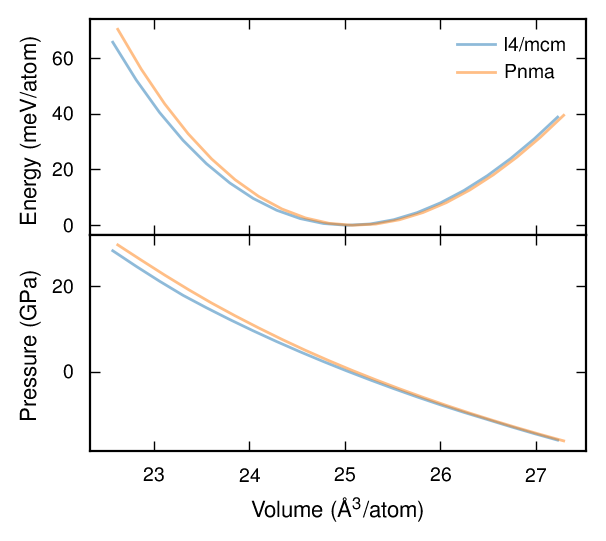

In [25]:
fig, axes = plt.subplots(
    figsize=(3.2, 2.8),
    dpi=200,
    nrows=2,
    sharex=True,
)

for sname, df in df_energies.groupby('sname'):
    kwargs = dict(
        alpha=0.5,
        label=labels[sname],
        color=colors[sname],
    )
    axes[0].plot(df.volume / df.natoms, 1e3 * (df.energy - df.energy.min()) / df.natoms, **kwargs)
    axes[1].plot(df.volume / df.natoms, df.pressure, **kwargs)

axes[0].set_ylabel('Energy (meV/atom)')
axes[1].set_ylabel('Pressure (GPa)')
axes[-1].set_xlabel('Volume (Å$^3$/atom)')

axes[0].legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [26]:
dfs_thermo = {}
dfs_dos = {}
for classical in [True, False]:
    dfs_dos[classical] = {}
    dfs_thermo[classical] = {}
    label = 'classical' if classical else 'quantum'
    for sname in phonons:
        print(f'classical: {classical}   sname: {sname}')
        dfs_dos[classical][sname] = {}
        dfs_thermo[classical][sname] = {}
        for volsc, ph in tqdm(phonons[sname].items()):
            dosfile = f'runs-{xc}/dos-{sname}-volsc{volsc:.3f}-{label}.json'
            thermofile = f'runs-{xc}/thermo-{sname}-volsc{volsc:.3f}-{label}.json'
            try:
                dos = read_json(dosfile)
                thermo = read_json(thermofile)
            except:
                thermo, dos = get_props(ph, classical, t_min=1, t_max=700, t_step=1)
                thermo.to_json(thermofile)
                dos.to_json(dosfile)
            dfs_thermo[classical][sname][volsc] = thermo
            dfs_dos[classical][sname][volsc] = dos

classical: True   sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [03:13<00:00,  9.66s/it]


classical: True   sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [12:37<00:00, 37.87s/it]


classical: False   sname: BaZrS3-spg140-I4mcm


100%|██████████| 20/20 [03:42<00:00, 11.11s/it]


classical: False   sname: BaZrS3-spg62-Pnma


100%|██████████| 20/20 [14:18<00:00, 42.93s/it]


volmin: 0.920   volmax: 1.100
volmin: 0.920   volmax: 1.110


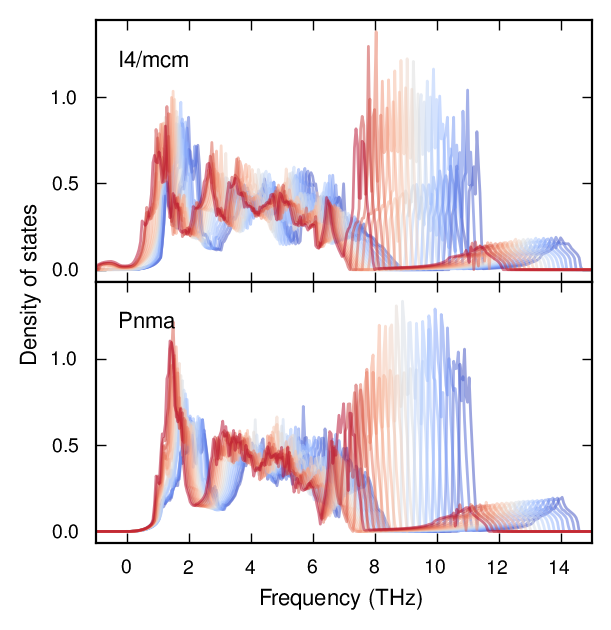

In [30]:
fig, axes = plt.subplots(
    figsize=(3.2, 3.4),
    dpi=200,
    nrows=len(dfs_dos[True]),
    sharex=True,
    sharey=True,
)

cmap = colormaps['coolwarm']
classical = True

volsc_limits = {
    'BaZrS3-spg140-I4mcm': (0.9, 1.1),
    'BaZrS3-spg62-Pnma': (0.9, 1.3)
}

for k, sname in enumerate(dfs_dos[classical]):
    axes[k].text(0.05, 0.82, labels[sname], transform=axes[k].transAxes)
    volmin, volmax = volsc_limits[sname]
    volmin = max(volmin, np.min(list(dfs_dos[classical][sname].keys())))
    volmax = min(volmax, np.max(list(dfs_dos[classical][sname].keys())))
    print(f'volmin: {volmin:.3f}   volmax: {volmax:.3f}')
    for volsc, df in dfs_dos[classical][sname].items():
        if volsc < volmin or volsc > volmax:
            continue
        df = df[df.frequency < 20]
        xrel = (volsc - volmin) / (volmax - volmin)
        kwargs = dict(
            alpha=0.5,
            color=cmap(xrel),
        )
        axes[k].plot(df.frequency, df.total_dos, **kwargs)

ax = axes[-1]
ax.set_xlabel('Frequency (THz)')
ax.set_ylabel('Density of states', y=1)
ax.set_xlim(-1, 15)

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

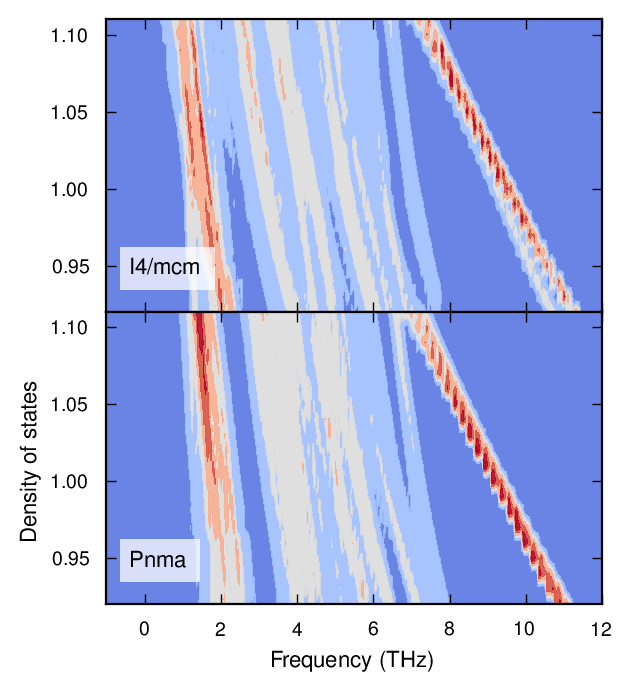

In [31]:
fig, axes = plt.subplots(
    figsize=(3.2, 3.8),
    dpi=200,
    nrows=len(dfs_dos[True]),
    sharex=True,
    sharey=True,
)

classical = True
for k, sname in enumerate(dfs_dos[classical]):
    df_dos = DataFrame()
    for volsc, df in dfs_dos[classical][sname].items():
        df['volsc'] = volsc
        df_dos = pd_concat([df_dos, df], ignore_index=True)

    ax = axes[k]
    ax.text(0.05, 0.13, labels[sname], transform=ax.transAxes, bbox=dict(lw=0, color='white', alpha=0.75))
    df_dos = df_dos[df_dos.frequency < 12]
    ax.tricontourf(df_dos.frequency, df_dos.volsc, df_dos.total_dos,
                   alpha=0.9, vmin=0, vmax=1, cmap='coolwarm')

axes[1].set_ylabel('Density of states')
ax = axes[-1]
ax.set_xlabel('Frequency (THz)')
ax.set_xlim(-1, 12)

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

-2.0386431163394656
0.005784957307617411


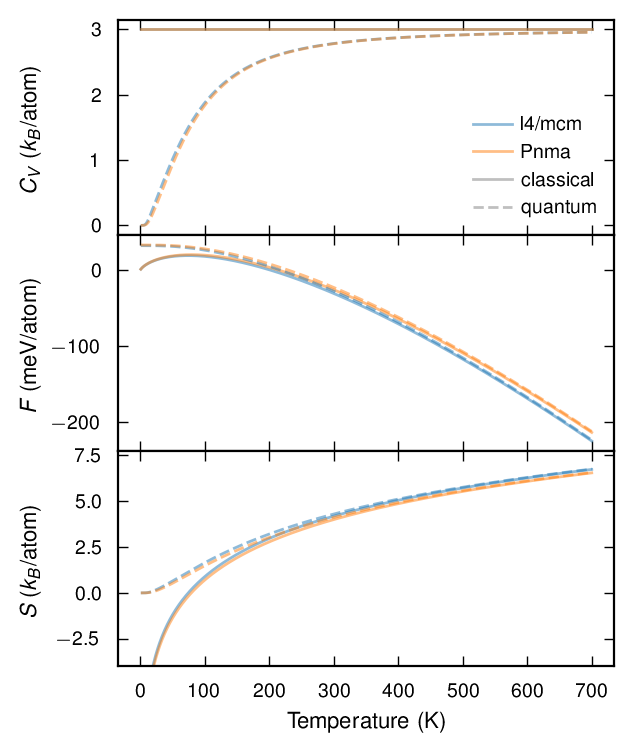

In [32]:
fig, axes = plt.subplots(
    figsize=(3.2, 4.2),
    dpi=200,
    nrows=3,
    sharex=True,
)

volsc = 1.0

# energy difference at zero K
structure = get_structure(phonons['BaZrS3-spg140-I4mcm'][volsc])
structure.calc = CPUNEP(model_filename)
energy_difference = structure.get_potential_energy() / len(structure)
print(energy_difference)
structure = get_structure(phonons['BaZrS3-spg62-Pnma'][volsc])
structure.calc = CPUNEP(model_filename)
energy_difference -= structure.get_potential_energy() / len(structure)
print(energy_difference)

for classical in dfs_thermo:
    for sname in dfs_thermo[classical]:
        df = dfs_thermo[classical][sname][1.0]
        kwargs = dict(
            alpha=0.5,
            label=labels[sname] if classical else '',
            color=colors[sname],
            ls='-' if classical else '--',
        )
        axes[0].plot(df.temperature, df.heat_capacity_kB, **kwargs)
        axes[1].plot(df.temperature, 1e3 * df.free_energy_eV, **kwargs)
        axes[2].plot(df.temperature, df.entropy_kB, **kwargs)

ax = axes[0]
ax.plot(np.nan, np.nan, '-', color='0.5', alpha=0.5, label='classical')
ax.plot(np.nan, np.nan, '--', color='0.5', alpha=0.5, label='quantum')

axes[0].set_ylabel('$C_V$ ($k_B$/atom)')
axes[1].set_ylabel('$F$ (meV/atom)')
axes[2].set_ylabel('$S$ ($k_B$/atom)')
axes[2].set_ylim(bottom=-4)
axes[-1].set_xlabel('Temperature (K)')

axes[0].legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

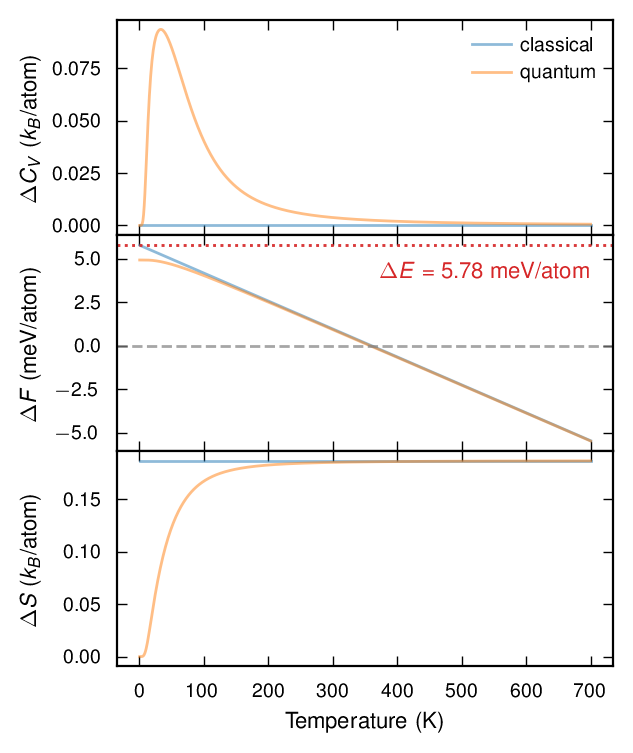

In [33]:
fig, axes = plt.subplots(
    figsize=(3.2, 4.2),
    dpi=200,
    nrows=3,
    sharex=True,
)

for classical in [True, False]:
    df1 = dfs_thermo[classical]['BaZrS3-spg62-Pnma'][volsc]
    df2 = dfs_thermo[classical]['BaZrS3-spg140-I4mcm'][volsc]
    kwargs = dict(
        alpha=0.5,
        label='classical' if classical else 'quantum',
    )
    axes[0].plot(df1.temperature, df2.heat_capacity_kB - df1.heat_capacity_kB, **kwargs)
    axes[1].plot(df1.temperature, 1e3 * (energy_difference + df2.free_energy_eV - df1.free_energy_eV), **kwargs)
    axes[1].axhline(1e3 * (energy_difference), color='C3', ls=':', alpha=0.7)
    axes[2].plot(df1.temperature, df2.entropy_kB - df1.entropy_kB, **kwargs)

axes[0].set_ylabel(r'$\UG{\Delta}C_V$ ($k_B$/atom)')
axes[1].set_ylabel(r'$\UG{\Delta}F$ (meV/atom)')
axes[2].set_ylabel(r'$\UG{\Delta}S$ ($k_B$/atom)')

axes[1].text(0.53, 0.8, r'$\UG{\Delta}E =' + f' {1e3 * energy_difference:.2f}$ meV/atom',
             transform=axes[1].transAxes, color='C3')

axes[1].axhline(0, color='0.5', ls='--', alpha=0.7)

axes[0].legend()
axes[-1].set_xlabel('Temperature (K)')

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

In [34]:
def get_qha_data(sname, classical):
    volmin, volmax = volsc_limits[sname]

    df = df_energies[df_energies.sname == sname]
    df = df[(df.volsc >= volmin) & (df.volsc <= volmax)]
    
    volumes = df.volume
    electronic_energies = df.energy
    pressure = df.pressure
    
    df = dfs_thermo[classical][sname][1.0]
    temperatures = df.temperature
    
    free_energy, entropy, cv = [], [], []
    for volsc, df in dfs_thermo[classical][sname].items():
        if volsc < volmin or volsc > volmax:
            continue
        free_energy.append(list(df.free_energy))
        entropy.append(list(df.entropy))
        cv.append(list(df.heat_capacity))
    free_energy = np.array(free_energy).T
    entropy = np.array(entropy).T
    cv = np.array(cv).T
    
    qha = PhonopyQHA(
        volumes=volumes,
        electronic_energies=electronic_energies,
        temperatures=temperatures,
        free_energy=free_energy,
        entropy=entropy,
        cv=cv,
    )

    structure = get_structure(phonons[sname][1.0])
    natoms = len(structure)
    
    data = np.array([
        temperatures[1:],
        qha.gibbs_temperature,
        qha.volume_temperature,
        qha.thermal_expansion,
        qha.bulk_modulus_temperature,
        qha.heat_capacity_P_polyfit,
        qha.heat_capacity_P_numerical,
    ])
    
    columns = [
        'temperature',
        'gibbs_free_energy',
        'volume',
        'thermal_expansion',
        'bulk_modulus',
        'heat_capacity_fit',
        'heat_capacity_num',
    ]
    
    df = DataFrame(data, columns).T
    df.gibbs_free_energy /= natoms
    df.volume /= natoms
    df.heat_capacity_fit /= natoms * R
    df.heat_capacity_num /= natoms * R

    return df


dfs_qha = {}
for classical in [True, False]:
    label = 'classical' if classical else 'quantum'
    dfs_qha[classical] = {}
    for sname in phonons:
        print(classical, sname)
        df = get_qha_data(sname, classical)
        dfs_qha[classical][sname] = df
        df.to_json(f'thermo-{xc}-{sname}-{label}.json')

True BaZrS3-spg140-I4mcm
True BaZrS3-spg62-Pnma
False BaZrS3-spg140-I4mcm
False BaZrS3-spg62-Pnma


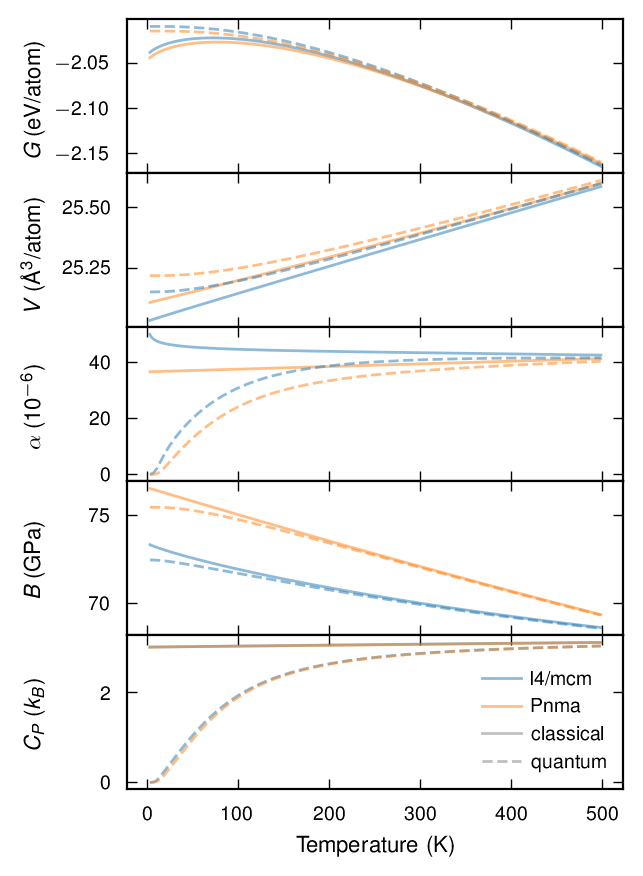

In [35]:
fig, axes = plt.subplots(
    figsize=(3.2, 5.0),
    dpi=200,
    nrows=5,
    sharex=True,
)

for classical in dfs_qha:
    for sname, df in dfs_qha[classical].items():
        kwargs = dict(
            alpha=0.5,
            label=labels[sname] if classical else '',
            color=colors[sname],
            ls='-' if classical else '--',
        )
    
        df = df[(df.temperature > 2) & (df.temperature < 500)]
        axes[0].plot(df.temperature, df.gibbs_free_energy, **kwargs)
        axes[1].plot(df.temperature, df.volume, **kwargs)
        axes[2].plot(df.temperature, df.thermal_expansion * 1e6, **kwargs)
        axes[3].plot(df.temperature, df.bulk_modulus, **kwargs)
        axes[4].plot(df.temperature, df.heat_capacity_fit, **kwargs)

axes[0].set_ylabel('$G$ (eV/atom)')
axes[1].set_ylabel('$V$ (Å$^3$/atom)')
axes[2].set_ylabel(r'$\alpha$ ($10^{-6}$)')
axes[3].set_ylabel('$B$ (GPa)')
axes[4].set_ylabel('$C_P$ ($k_B$)')
axes[-1].set_xlabel('Temperature (K)')

ax = axes[-1]
ax.plot(np.nan, np.nan, '-', color='0.5', alpha=0.5, label='classical')
ax.plot(np.nan, np.nan, '--', color='0.5', alpha=0.5, label='quantum')
ax.legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

classical  328 K
quantum    326 K


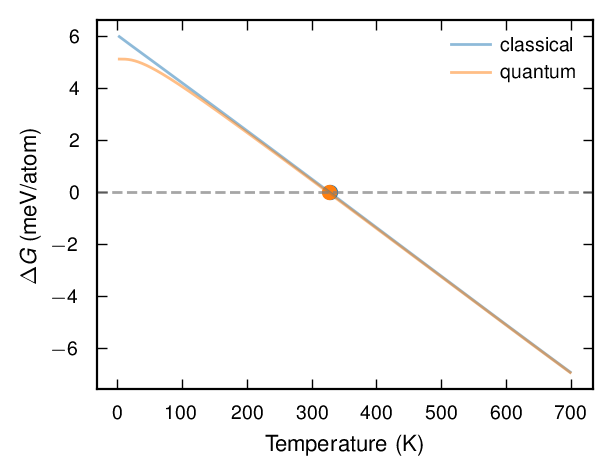

In [42]:
fig, ax = plt.subplots(
    figsize=(3.2, 2.4),
    dpi=200,
)

for classical in dfs_qha:
    df = dfs_qha[classical]['BaZrS3-spg62-Pnma']
    df2 = dfs_qha[classical]['BaZrS3-spg140-I4mcm']

    df['delta_gibbs_free_energy'] = df2.gibbs_free_energy - df.gibbs_free_energy
    df = df[(df.temperature > 2) & (df.temperature < 700)]

    label = 'classical' if classical else 'quantum'
    kwargs = dict(
        alpha=0.5,
        label=label,
    )
    ax.plot(df.temperature, 1e3 * df.delta_gibbs_free_energy, **kwargs)
    k = df.delta_gibbs_free_energy.abs().idxmin()
    transition_temperature = df.iloc[k].temperature
    print(f'{label:10} {transition_temperature:3.0f} K')
    ax.scatter(transition_temperature, 0)

ax.axhline(0, color='0.5', alpha=0.7, ls='--')
ax.set_ylabel(r'$\UG{\Delta}G$ (meV/atom)')
ax.set_xlabel('Temperature (K)')

ax.legend()

fig.subplots_adjust(hspace=0)
fig.align_ylabels()

/var/folders/z6/b_jzphk53190vbrxr2tb1l980000gn/T/ipykernel_87537/2795623407.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


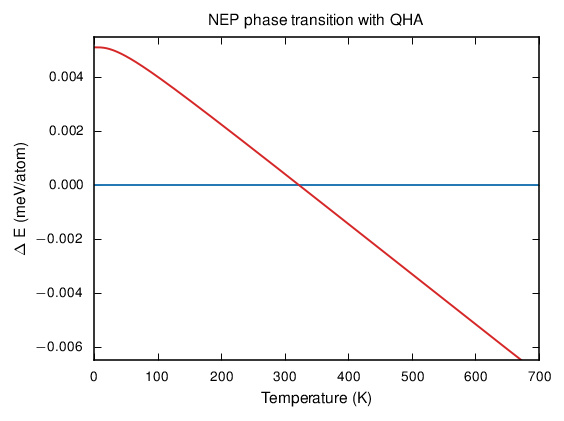

In [44]:
fig, ax = plt.subplots(figsize=(4.1, 3), dpi=140)
df_ort = dfs_qha[False]['BaZrS3-spg62-Pnma']
df2_tet = dfs_qha[False]['BaZrS3-spg140-I4mcm']
ax.set_xlim([0,700])
ax.set_ylim([-0.0065,0.0055])
ax.plot(df2_tet.gibbs_free_energy-df2.gibbs_free_energy, color="tab:blue")
ax.plot(df2_tet.gibbs_free_energy-df.gibbs_free_energy, color= "tab:red")
ax.set_title(f'NEP phase transition with QHA')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\UG{\Delta}$ E (meV/atom)')
ax.legend()
fig.savefig('QHA_NEP.png', bbox_inches='tight')